# Temporal Analysis of SIF and XCO2
---

In [66]:
from functools import reduce
import numpy as np
import pandas as pd
import xarray

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize_scalar

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy

In [2]:
from dask.distributed import Client
client = Client(n_workers=16, dashboard_address=":8889")
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:38929 Dashboard: http://127.0.0.1:8889/status,Cluster Workers: 16 Cores: 64 Memory: 270.51 GB


In [148]:
client.close()

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nann

## Data processing

In [140]:
def prep_sif(ds):
    """Preprocess a SIF Lite file"""
    
    # Drop unused variables
    variable_list = ["Daily_SIF_740nm", "SIF_Uncertainty_740nm", "Quality_Flag", "Longitude", "Latitude", "Delta_Time"]
    ds = ds[variable_list]
    
    # Apply quality filters
    ds["SIF_plus_3sig"] = ds.Daily_SIF_740nm + 3*ds.SIF_Uncertainty_740nm
    ds = ds.where(ds.Quality_Flag != 2, drop=True)
    ds = ds.where(ds.SIF_plus_3sig > 0, drop=True)

    # Format dataset
    dsnew = xarray.Dataset(
        {
            "sif": (["time"], ds.Daily_SIF_740nm),
        },
        coords={
            "lon": (["time"], ds.Longitude),
            "lat": (["time"], ds.Latitude),
            "time": ds.Delta_Time.values
        }
    )
    return dsnew


def prep_xco2(ds):
    """Preprocess an FP Lite file"""
    
    # Drop unused variables
    variable_list = ["xco2", "xco2_quality_flag", "longitude", "latitude", "time"]
    ds = ds[variable_list]
    
    # Apply quality filters
    ds = ds.where(ds.xco2_quality_flag == 0, drop=True)

    # Format dataset
    dsnew = xarray.Dataset(
        {
            "xco2": (["time"], ds.xco2),
        },
        coords={
            "lon": (["time"], ds.longitude),
            "lat": (["time"], ds.latitude),
            "time": ds.time.values
        }
    )
    return dsnew

def regrid(ds, res=1, bands=None, transcom=False):
    """
    Convert dataset to dataframe and assign coordinates to designated grid.
    """
    df = ds.to_dataframe()
        
    # Establish grid
    lon_bins = np.arange(-180, 180+res, res)
    lat_bins = np.arange(-90, 90+res, res)
    lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
    lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2

    if bands == "lon"
        df["lon"] = pd.cut(df.lon, lon_bins, labels=lon_centers).astype(float)
        df.drop(columns=["lat"], inplace=True)
    else if bands == "lat":
        df["lat"] = pd.cut(df.lat, lat_bins, labels=lat_centers).astype(float)
        df.drop(columns=["lon"], inplace=True)
    else:
        df["lon"] = pd.cut(df.lon, lon_bins, labels=lon_centers).astype(float)
        df["lat"] = pd.cut(df.lat, lat_bins, labels=lat_centers).astype(float)
    
    return df

In [5]:
# Open datasets for all years
paths_sif = "/data/OCO-2/OCO2_L2_Lite_SIF.10r/*/*.nc4"
paths_xco2 = "/data/OCO-2/OCO2_L2_Lite_FP.10r/*/*.nc4"

DS_sif = xarray.open_mfdataset(paths_sif, preprocess=prep_sif, parallel=True)
DS_xco2 = xarray.open_mfdataset(paths_xco2, preprocess=prep_xco2, parallel=True)

# NOTE: Date range = 2014-09-06 : 2020-07-31

In [145]:
DS_sif.to_dataframe()

,sif,lon,lat
time,,,
2014-09-06 01:47:19.054687488,-0.124627,179.950684,-18.575500
2014-09-06 01:47:48.304687488,0.086637,179.573730,-16.785889
2014-09-06 01:47:51.054687488,0.535007,179.513550,-16.646545
2014-09-06 01:47:51.085937536,0.603849,179.505493,-16.653625
2014-09-06 01:47:51.257812480,0.535095,179.548218,-16.589966
...,...,...,...
2020-07-31 23:20:37.726562560,0.027987,-178.023193,71.435669
2020-07-31 23:20:38.031250048,0.687958,-178.099487,71.457092
2020-07-31 23:20:43.226562560,0.107720,-178.857422,71.723206


In [113]:
DS_sif

<xarray.Dataset>
Dimensions:  (time: 241812820)
Coordinates:
    lon      (time) float32 179.95068 179.57373 ... -178.81311 -178.76868
    lat      (time) float32 -18.5755 -16.785889 ... 71.71771 71.712036
  * time     (time) datetime64[ns] 2014-09-06T01:47:19.054687488 ... 2020-07-...
Data variables:
    sif      (time) float32 -0.12462711 0.0866375 ... 0.17045212 0.38776588

## Monthly and daily climatology comparison

In [7]:
# Compute monthly climatologies
df_sif_monthly = DS_sif.sif.resample(time="1MS").mean(dim="time").to_dataframe()
df_xco2_monthly = DS_xco2.xco2.resample(time="1MS").mean(dim="time").to_dataframe()
df_monthly = pd.merge(df_sif_monthly, df_xco2_monthly, how="outer", on=["time"]).reset_index()

# Compute daily climatologies
df_sif_daily = DS_sif.sif.resample(time="1D").mean(dim="time").to_dataframe()
df_xco2_daily = DS_xco2.xco2.resample(time="1D").mean(dim="time").to_dataframe()
df_daily = pd.merge(df_sif_daily, df_xco2_daily, how="outer", on=["time"]).reset_index()

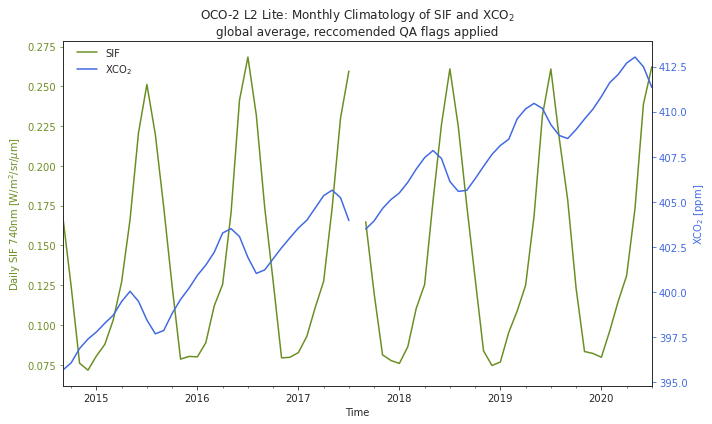

In [8]:
# Plot global monthly climatology
sns.set_style("ticks")
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Set variable colors
sif_color = "olivedrab"
xco2_color = "royalblue"

# Line plots
df_monthly.plot(x="time", y="sif", color=sif_color, ax=ax1, legend=False, label="SIF")
df_monthly.plot(x="time", y="xco2", color=xco2_color, ax=ax2, legend=False, label="XCO$_2$")

# Customize axes
# plt.locator_params(axis="x", nbins=8)
ax1.tick_params(axis="y", colors=sif_color)
ax2.tick_params(axis="y", colors=xco2_color)
ax1.yaxis.label.set_color(sif_color)
ax2.yaxis.label.set_color(xco2_color)
ax1.figure.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), frameon=False)

# Add titles
ax1.set_xlabel("Time")
ax1.set_ylabel("Daily SIF 740nm [W/m$^2$/sr/$\mu$m]")
ax2.set_ylabel("XCO$_2$ [ppm]")
ax1.set_title("OCO-2 L2 Lite: Monthly Climatology of SIF and XCO$_2$\n"
              "global average, reccomended QA flags applied")

plt.tight_layout()
# plt.savefig("../plots/monthly_climatology_comparison.png")

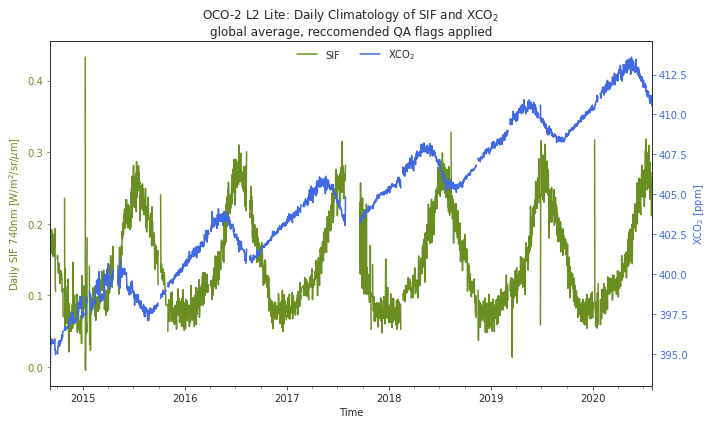

In [14]:
# Plot global daily climatology
sns.set_style("ticks")
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Set variable colors
sif_color = "olivedrab"
xco2_color = "royalblue"

# Line plots
df_daily.plot(x="time", y="sif", color=sif_color, ax=ax1, legend=False, label="SIF")
df_daily.plot(x="time", y="xco2", color=xco2_color, ax=ax2, legend=False, label="XCO$_2$")

# Customize axes
# plt.locator_params(axis="x", nbins=8)
ax1.tick_params(axis="y", colors=sif_color)
ax2.tick_params(axis="y", colors=xco2_color)
ax1.yaxis.label.set_color(sif_color)
ax2.yaxis.label.set_color(xco2_color)
ax1.figure.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 0.9), frameon=False)

# Add titles
ax1.set_xlabel("Time")
ax1.set_ylabel("Daily SIF 740nm [W/m$^2$/sr/$\mu$m]")
ax2.set_ylabel("XCO$_2$ [ppm]")
ax1.set_title("OCO-2 L2 Lite: Daily Climatology of SIF and XCO$_2$\n"
              "global average, reccomended QA flags applied")

plt.tight_layout()
plt.savefig("../plots/daily_climatology_comparison.png")

## Analysis of lagged anomalies

### Monthly

In [18]:
## Create a dataframe of SIF residuals and XCO2 residuals lagged by 0-4 months

# Interpolate missing values
df_monthly_interp = df_monthly.interpolate().set_index("time")

# Fit trends by least squares
X = (df_monthly_interp.index - df_monthly_interp.index[0]).days.values.reshape(-1, 1)
trend_sif = LinearRegression().fit(X, df_monthly_interp.sif).predict(X)
trend_xco2 = LinearRegression().fit(X, df_monthly_interp.xco2).predict(X)

# Remove trends
df_monthly_interp["sif_anom"] = df_monthly_interp.sif - trend_sif
df_monthly_interp["xco2_anom_lag0"] = df_monthly_interp.xco2 - trend_xco2

# Apply monthly lag
for t in range(1, 5):
    df_monthly_interp[f"xco2_anom_lag{t}"] = df_monthly_interp.xco2_anom_lag0.shift(t)
    
df_monthly_interp

,sif,xco2,sif_anom,xco2_anom_lag0,xco2_anom_lag1,xco2_anom_lag2,xco2_anom_lag3,xco2_anom_lag4
time,,,,,,,,
2014-09-01,0.168572,395.663696,0.035291,-1.349719,NaN,NaN,NaN,NaN
2014-10-01,0.124161,396.069519,-0.009437,-1.157817,-1.349719,NaN,NaN,NaN
2014-11-01,0.075926,396.865021,-0.057999,-0.583367,-1.157817,-1.349719,NaN,NaN
2014-12-01,0.071579,397.389465,-0.062663,-0.272843,-0.583367,-1.157817,-1.349719,NaN
2015-01-01,0.080472,397.781097,-0.054098,-0.102263,-0.272843,-0.583367,-1.157817,-1.349719
...,...,...,...,...,...,...,...,...
2020-03-01,0.114833,412.062805,-0.039666,0.730943,0.486683,-0.068846,-0.542557,-0.877434
2020-04-01,0.130919,412.694336,-0.023908,1.141422,0.730943,0.486683,-0.068846,-0.542557
2020-05-01,0.173319,413.028992,0.018175,1.262157,1.141422,0.730943,0.486683,-0.068846


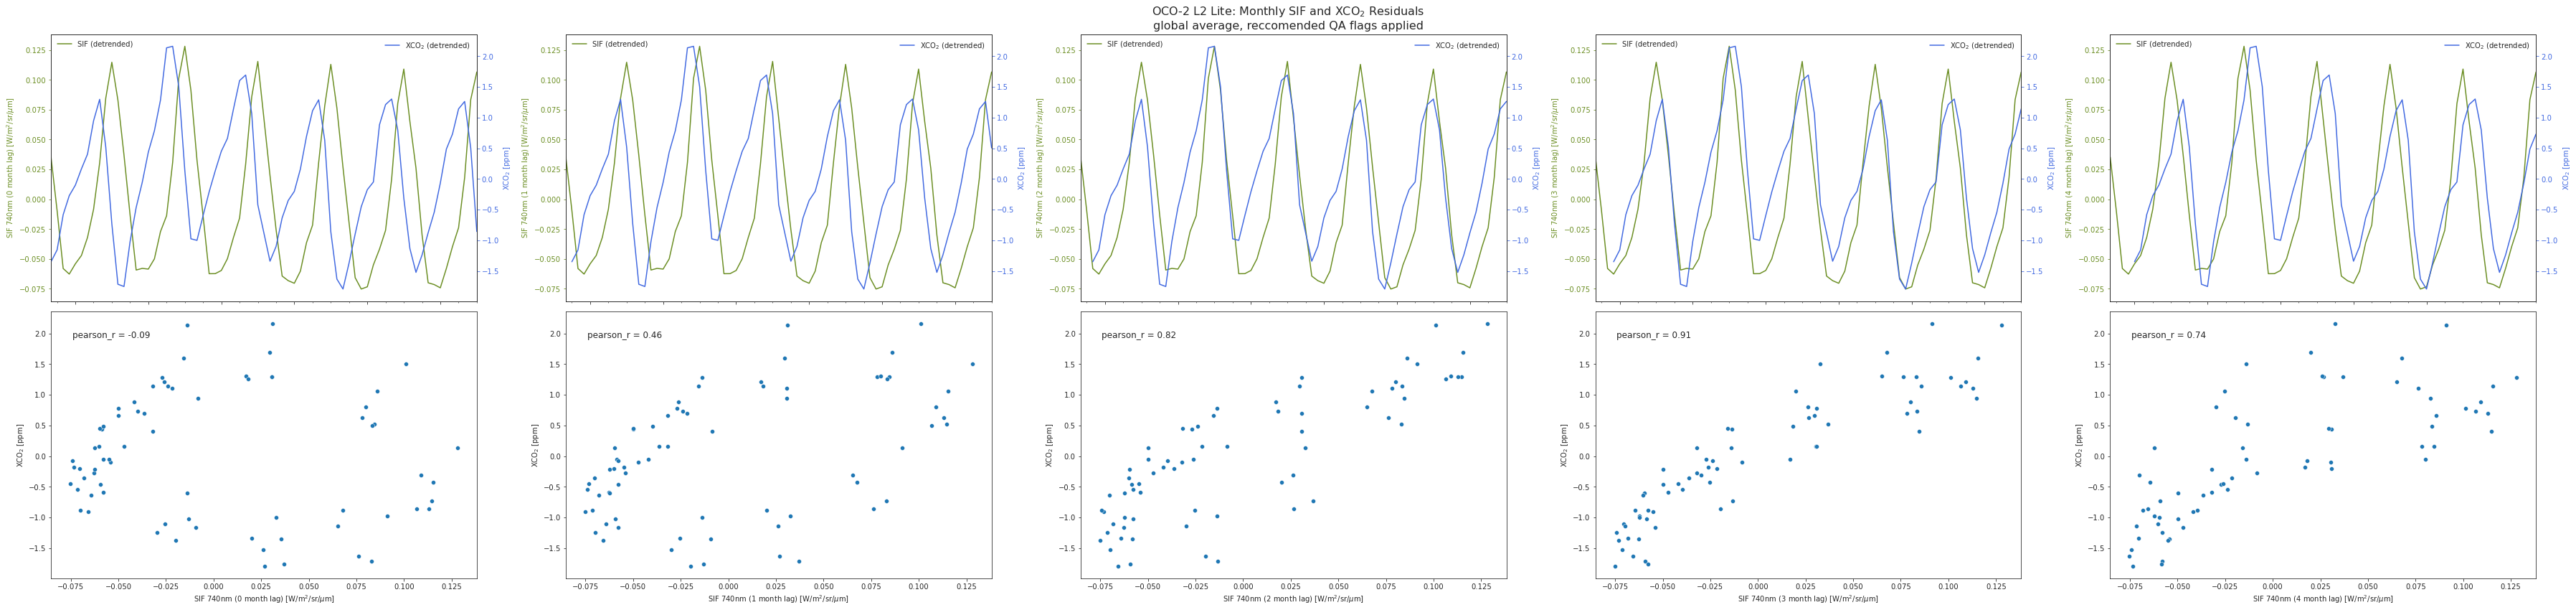

In [45]:
## Create grid of figures with timeseries on top row and scatter plots on bottom
fig, axes = plt.subplots(2, 5, figsize=(50, 12))
fig.subplots_adjust(top=0.85)
fig.suptitle("OCO-2 L2 Lite: Monthly SIF and XCO$_2$ Residuals\n"
             "global average, reccomended QA flags applied",
             size=16)

sif_color = "olivedrab"
xco2_color = "royalblue"

# Time series
for j in range(5):
    ax1 = axes[0, j]
    ax2 = ax1.twinx()
    
    df_monthly_interp.plot(y="sif_anom", use_index=True, color=sif_color, ax=ax1, legend=False, label="SIF (detrended)")
    df_monthly_interp.plot(y=f"xco2_anom_lag{j}", use_index=True, color=xco2_color, ax=ax2, legend=False, label="XCO$_2$ (detrended)")

    # Customize axes
    ax1.tick_params(axis="y", colors=sif_color)
    ax2.tick_params(axis="y", colors=xco2_color)
    ax1.yaxis.label.set_color(sif_color)
    ax2.yaxis.label.set_color(xco2_color)
    ax1.legend(loc="upper left", frameon=False)
    ax2.legend(loc="upper right", frameon=False)

    # Add titles
    ax1.set_xlabel("Time")
    ax1.set_ylabel(f"SIF 740nm ({j} month lag) [W/m$^2$/sr/$\mu$m]")
    ax2.set_ylabel("XCO$_2$ [ppm]")
    
    
# Scatterplots
for j in range(5):
    pearson_corr = df_monthly_interp.sif_anom.corr(df_monthly_interp[f"xco2_anom_lag{j}"])
    sns.scatterplot(x="sif_anom", y=f"xco2_anom_lag{j}", data=df_monthly_interp, ax=axes[1, j])
    axes[1, j].annotate("pearson_r = {:.2f}".format(pearson_corr), fontsize=12,
                        xy=(0.1, 0.9), xytext=(0.05, 0.9), textcoords="axes fraction")
    axes[1, j].set_xlabel(f"SIF 740nm ({j} month lag) [W/m$^2$/sr/$\mu$m]")
    axes[1, j].set_ylabel("XCO$_2$ [ppm]")


plt.tight_layout()
plt.savefig("../plots/monthly_lagged_residual_analysis.png")

### Daily

In [64]:
# Interpolate missing values
df_daily_interp = df_daily.interpolate().set_index("time")

# Fit trends by least squares
X = (df_daily_interp.index - df_daily_interp.index[0]).days.values.reshape(-1, 1)
trend_sif = LinearRegression().fit(X, df_daily_interp.sif).predict(X)
trend_xco2 = LinearRegression().fit(X, df_daily_interp.xco2).predict(X)

# Remove trends
df_daily_interp["sif_anom"] = df_daily_interp.sif - trend_sif
df_daily_interp["xco2_anom"] = df_daily_interp.xco2 - trend_xco2

In [93]:
# Objective function
def objective_corr(lag):
    """
    Wrapper to compute Pearson's correlation coeffient between two pandas series
    with a lag applied to the second series. Returns the negative of the magnitude
    of the correlation coef. for minimization purposes.
    """
    lag = np.int(np.rint(lag))
    return -np.abs(df_daily_interp.sif_anom.corr(df_daily_interp.xco2_anom.shift(lag)))

In [108]:
# Find the lag in days which maximizes the magnitude of the correlation coef. between global average residuals of SIF and XCO2
lag = minimize_scalar(objective_corr, bounds=[0, 360], method="Bounded")

# NOTE: does the integer rounding make this messy?
print(f"Optimal lag in days: {np.rint(lag.x)}")
lag

Optimal lag in days: 91.0


     fun: -0.8345212348583826
 message: 'Solution found.'
    nfev: 28
  status: 0
 success: True
       x: 90.9206416014259

In [107]:
[print(t, objective_corr(t)) for t in lags]

75 -0.8123377585140449
76 -0.8107212875236284
77 -0.8219064931623591
78 -0.8164372528685099
79 -0.8253663879040951
80 -0.8256221834751386
81 -0.8288670663100007
82 -0.8312491130046628
83 -0.8317848220541055
84 -0.8368381046891805
85 -0.830245447048871
86 -0.8383825046352671
87 -0.83411878639107
88 -0.8381612822515603
89 -0.8334069627204758
90 -0.8342253544455351
91 -0.8345212348583826
92 -0.827822173821715
93 -0.8348040121816661
94 -0.8290978297234423
95 -0.8315018541908666
96 -0.8221099478596625
97 -0.8248777365270115
98 -0.8208063315633951
99 -0.8168678561529366
100 -0.8191434236580709
101 -0.8125869487783426
102 -0.8137511611451435
103 -0.8037908161807936
104 -0.8056481570412987
105 -0.7986529707460036
106 -0.7946444917902105
107 -0.7931940305131623
108 -0.7853087347858263
109 -0.7872339047697003


In [112]:
lags = np.arange(75, 110)
lag_m = lags[np.argmin([objective_corr(t) for t in lags])]
print(f"Optimal lag in days: {lag_m}")

Optimal lag in days: 86


## 1-degree lagged correlation

In [28]:
# Aggregate both datasets to 1-degree monthly averages
DS_sif_grid = DS_sif.resample(time="1MS").map(regrid).groupby(["lon", "lat"]).mean().to_xarray()
DS_xco2_grid = DS_xco2.resample(time="1MS").map(regrid).groupby(["lon", "lat"]).mean().to_xarray()

In [29]:
# Create data frame joining SIF and lagged XCO2 by coordinates
df_sif = DS_sif_grid.to_dataframe().dropna().reset_index()
df_xco2 = DS_xco2_grid.to_dataframe().dropna().reset_index()

# Apply months lag
df_xco2["time"] = pd.DatetimeIndex( df_xco2["time"] ) + pd.DateOffset(months = 3)

# Perform inner join
df = pd.merge(df_sif, df_xco2, how="inner", on=["lon", "lat", "time"])
df["time"] = df.time.dt.strftime("%Y-%m")
df.sort_values(by="time", inplace=True)

In [30]:
df.head()

,lat,lon,time,sif,xco2
164617,25.5,-100.5,2014-12,0.210840,395.711975
153856,22.5,18.5,2014-12,-0.011871,395.927216
153906,22.5,19.5,2014-12,-0.022469,395.906403
154047,22.5,25.5,2014-12,-0.038195,394.138550
154121,22.5,30.5,2014-12,0.007249,393.447479


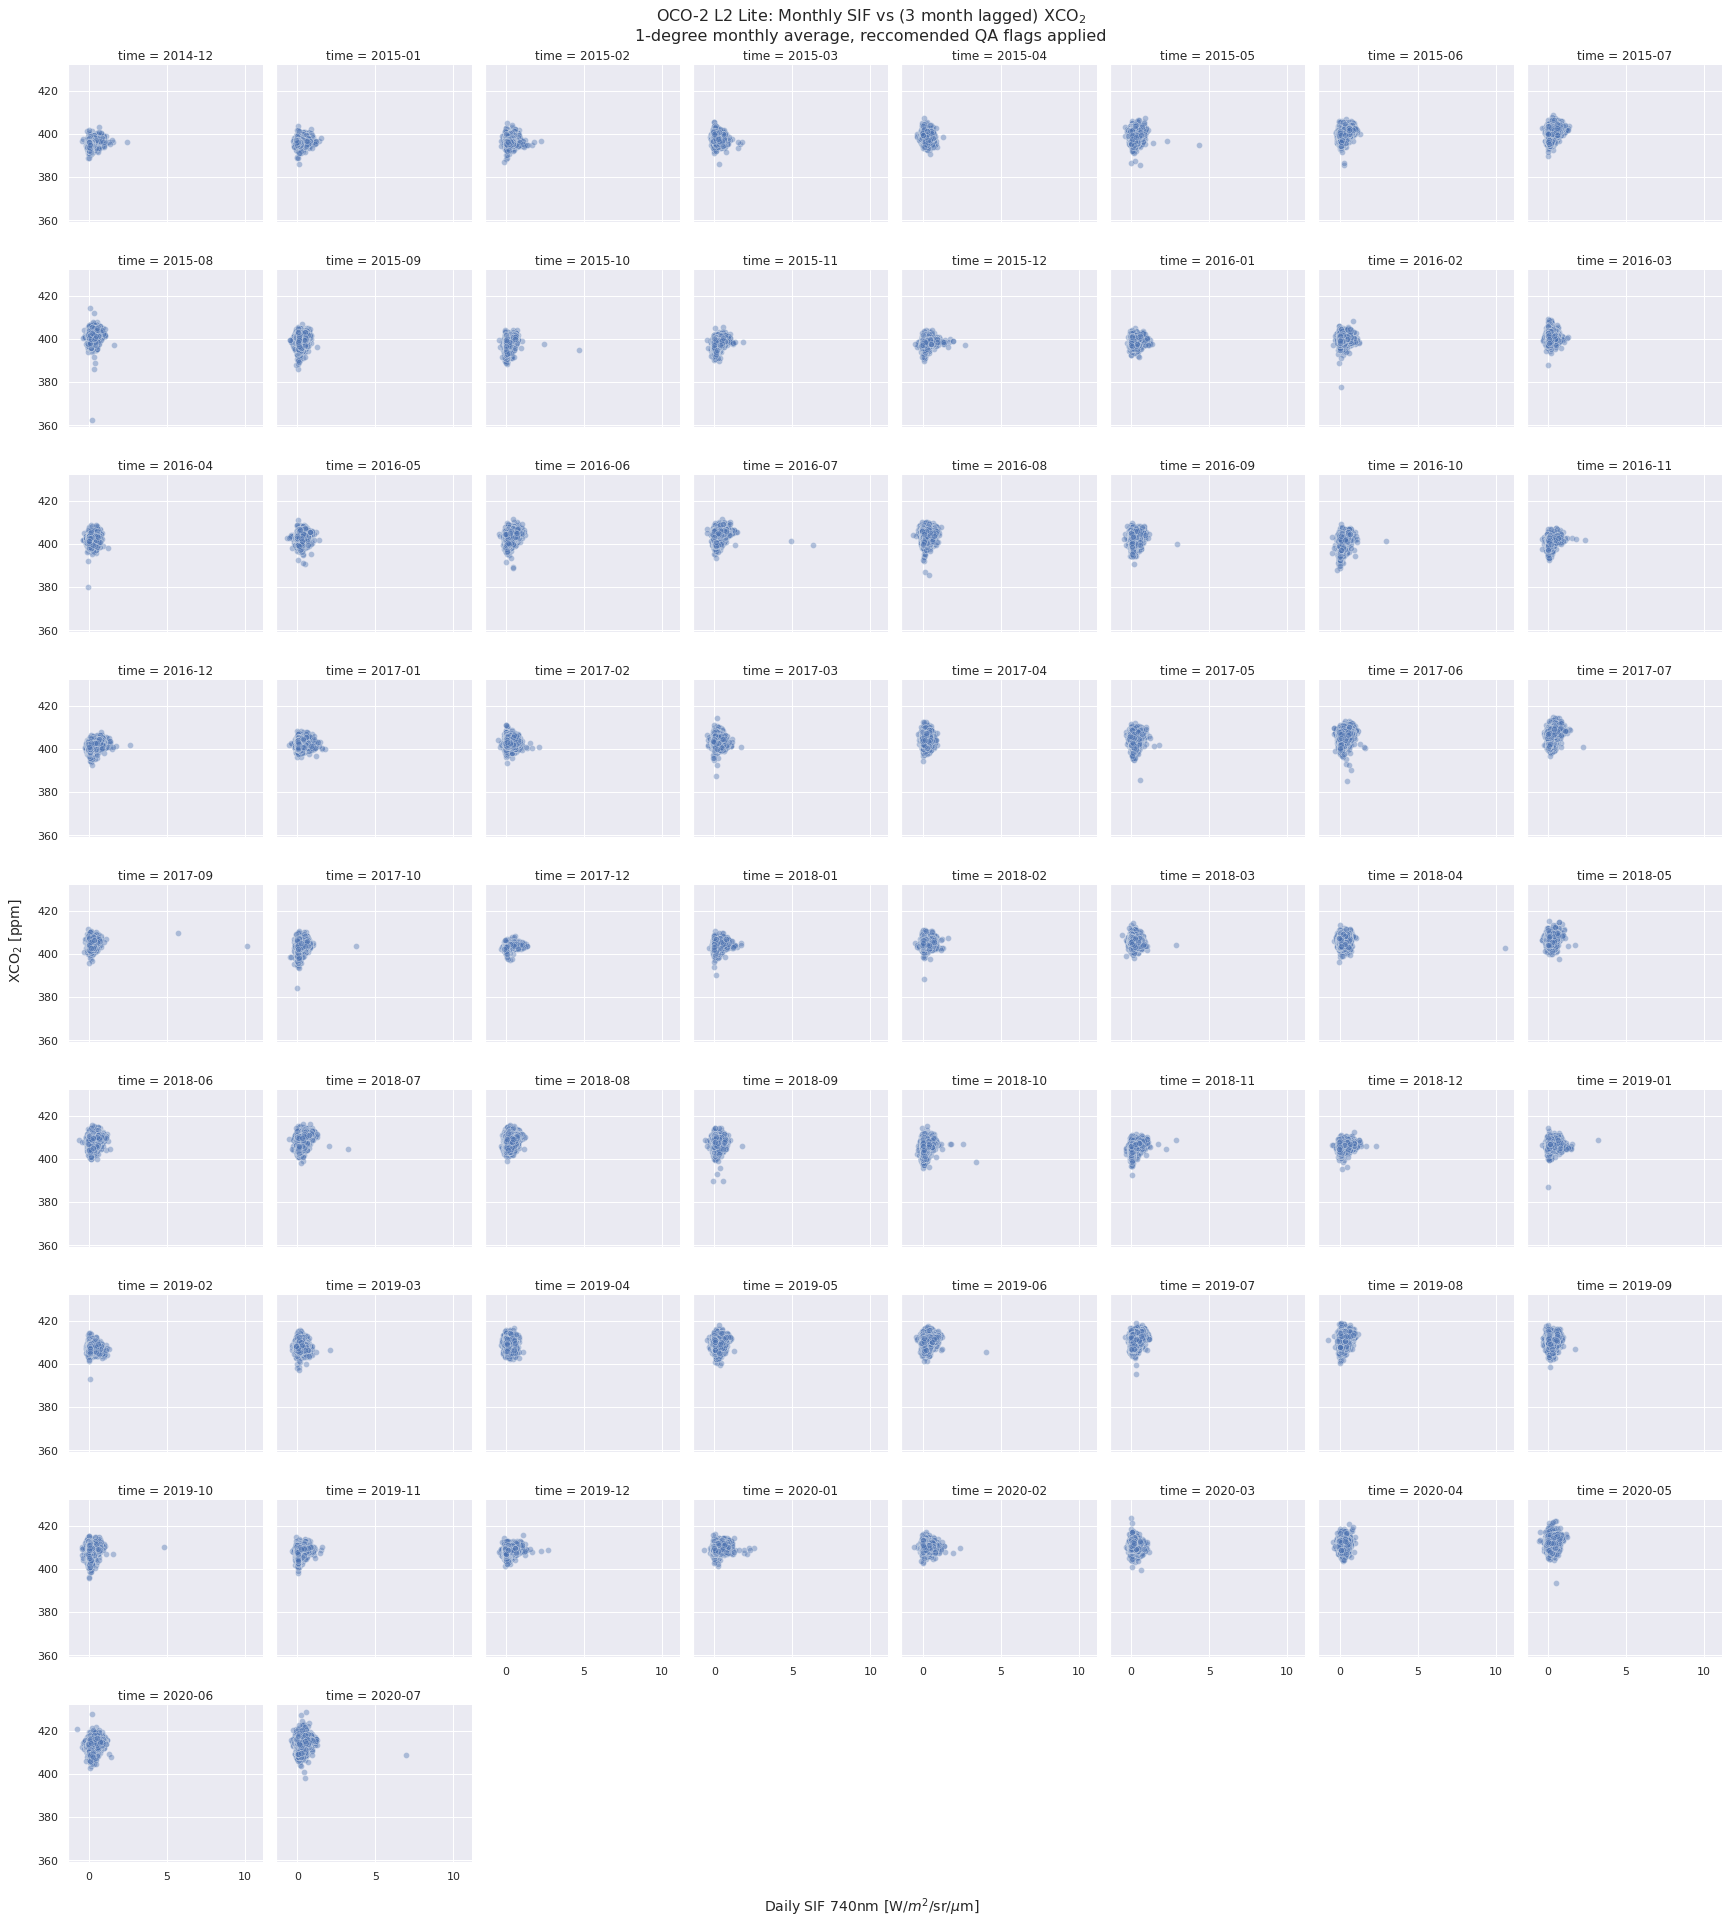

In [32]:
# Make scatter plots faceted by month
sns.set_theme()
g = sns.FacetGrid(df, col="time", col_wrap=8)
g.map(sns.scatterplot, "sif", "xco2", alpha=0.4)

plt.subplots_adjust(top=0.95)
g.fig.suptitle(f"OCO-2 L2 Lite: Monthly SIF vs ({lag} month lagged) XCO$_2$\n" 
               "1-degree monthly average, reccomended QA flags applied",
               size=16)

#this surpresses the x- and y-labels on each axes of the bottom/leftmost column
g.set_axis_labels("", "") 

# overall ylabel
g.fig.text(x=0, y=0.5, 
           verticalalignment="center",
           s="XCO$_2$ [ppm]",
           size=14,
           rotation=90)

#overall xlabel
g.fig.text(x=0.5, y=0, 
           horizontalalignment="center",
           s="Daily SIF 740nm [W/$m^2$/sr/$\mu$m]", 
           size=14)

plt.savefig("../plots/monthly_lagged_scatterplots.png")

## Cross-covariance analysis

In [131]:
def compute_xcov(v1, v2, lag):
    """
    Empirical cross-covariance
    Cressie and Wikle, Eq 5.4, single point.
    Parameters:
        - v1, v2: 1d numpy arrays
        - lag: integer lag in days
    Returns:
        - xcov: float
    """
    # truncate appropriate end of each vector to apply lag
    X = (v1 - np.nanmean(v1))[lag:]
    Y = (v2 - np.nanmean(v2))[:-lag]
    
    # Question: should the nan dates be included in the (T - lag) factor?
#     return np.dot(X, Y) / X.size
#     return np.nansum(X*Y) / X.size
    return np.nansum(X*Y) / X[~np.isnan(X)].size

def compute_xcov_nd(v1, v2, lag):
    ## Could maybe improve speed if we can figure out how to broadcast
    ## Also consider avoiding ufunc, instead apply cross_cov to pandas groups
    """
    Empirical cross-covariance
    Cressie and Wikle, Eq 5.4, single point.
    Parameters:
        - v1, v2: n-d numpy arrays
        - lag: integer lag in days
    Returns:
        - xcov: float
    """
    # apply mask for nan values
    v1_m = np.ma.array(v1, mask=np.isnan(v1))
    v2_m = np.ma.array(v2, mask=np.isnan(v2))
    
    # truncate along time dim at appropriate position to apply lag
    X = (v1_m - v1_m.mean(axis=-1, keepdims=True))[:, :, lag:]
    Y = (v2_m - v2_m.mean(axis=-1, keepdims=True))[:, :, :-lag]
    
#     return np.nansum(X*Y, axis=-1, keepdims=True) / X.shape[-1]
    # determine (T-lag) factor for each cell; 
    # find the number on non-nan values along time axis
    fact = np.count_nonzero(~np.isnan(X), axis=-1)
    
    # compute the inner product along the time dimension
    xcov = np.sum(X*Y, axis=-1) / fact
    
    # return data values with missing entries filled as nan
    return np.ma.filled(xcov.astype(float), np.nan)

    
def apply_cross_covariance(X, Y, lag=0):
    return xarray.apply_ufunc(
        compute_xcov_nd,
        X,
        Y,
        kwargs = {"lag": lag},
        input_core_dims = [["time"], ["time"]],
        dask = "parallelized",
        # vectorize = True, # needed if using 1-d cross-cov func
        output_dtypes = [float],
    )

## Daily

### Cross-covariance for a single 1-degree cell

In [179]:
## Analyze a single cell
time = pd.date_range("2014-09-06", "2020-07-31", freq="1D")

# Setup regional masks
region_sif = (
    (DS_sif.coords["lat"] >= 39)
    & (DS_sif.coords["lat"] < 40)
    & (DS_sif.coords["lon"] <= -89)
    & (DS_sif.coords["lon"] < -90)
)
region_xco2 = (
    (DS_xco2.coords["lat"] >= 39)
    & (DS_xco2.coords["lat"] < 40)
    & (DS_xco2.coords["lon"] <= -89)
    & (DS_xco2.coords["lon"] < -90)
)

# Select values in regional and compute daily average
df_region_sif = DS_sif.sif.where(region_sif, drop=True).resample(time="1D").mean(dim="time").to_dataframe().reset_index()
df_region_xco2 = DS_xco2.xco2.where(region_xco2, drop=True).resample(time="1D").mean(dim="time").to_dataframe().reset_index()

# Apply months lag
# df_region_xco2["time"] = pd.DatetimeIndex( df_region_xco2["time"] ) + pd.DateOffset(months = 2)

# Merge dataframes
frames = [time.to_frame(name="time"), df_region_sif, df_region_xco2]
df_region = reduce(lambda  left,right: pd.merge(left,right, on=["time"], how="outer"), frames).fillna(np.nan)
df_region

,time,sif,xco2
0,2014-09-07,0.419197,392.943848
3,2014-09-10,0.231892,393.473999
4,2014-09-11,0.019689,394.602448
7,2014-09-14,0.354859,393.015381
8,2014-09-15,0.157048,394.473206
...,...,...,...
2148,2020-07-25,0.012569,412.716095
2149,2020-07-26,0.914736,411.605530
2150,2020-07-27,0.191499,412.241913
2151,2020-07-28,0.477579,412.425079


In [385]:
compute_xcov(df_region.sif.values, df_region.xco2.values, lag=90)

0.20890484978170956

### Compute cross-covariance for each 1-degree cell and map values

In [426]:
time = pd.date_range("2014-09-06", "2020-07-31", freq="1D").to_frame(name="time")

# Cut datasets to a regular grid and resample to daily averages within each grid cell
df_sif_daily = regrid(DS_sif).groupby(["lon", "lat"]).resample("1D").mean().drop(columns=["lon", "lat"]).reset_index()
df_xco2_daily = regrid(DS_xco2).groupby(["lon", "lat"]).resample("1D").mean().drop(columns=["lon", "lat"]).reset_index()

# Merge dataframes
df_sif_daily_full = pd.merge(time, df_sif_daily, on=["time"], how="outer")
df_xco2_daily_full = pd.merge(time, df_xco2_daily, on=["time"], how="outer")
df_grid_daily = pd.merge(df_sif_daily_full, df_xco2_daily_full, on=["lon", "lat", "time"], how="outer")
df_grid_daily

,time,lon,lat,sif,xco2
0,2014-09-06,-165.5,61.5,0.095413,391.084167
1,2014-09-06,-165.5,62.5,0.020068,391.995697
2,2014-09-06,-164.5,59.5,0.031500,NaN
3,2014-09-06,-164.5,60.5,0.062653,393.286835
4,2014-09-06,-164.5,61.5,0.067781,391.895447
...,...,...,...,...,...
109575185,2020-07-31,179.5,-2.5,NaN,412.345093
109575186,2020-07-31,179.5,-1.5,NaN,412.422943
109575187,2020-07-31,179.5,-0.5,NaN,412.353271
109575188,2020-07-31,179.5,0.5,NaN,412.237396


In [432]:
# Check coverage
df_daily_counts = df_grid_daily.dropna().groupby(["lon", "lat"]).count()
df_daily_counts

time  sif  xco2
lon    lat                   
-179.5 -20.5     3    3     3
       -19.5    61   61    61
       -18.5    35   35    35
       -17.5    30   30    30
       -16.5    41   41    41
...            ...  ...   ...
 179.5  67.5    13   13    13
        68.5    18   18    18
        69.5     6    6     6
        70.5     8    8     8
        71.5    10   10    10

[18046 rows x 3 columns]

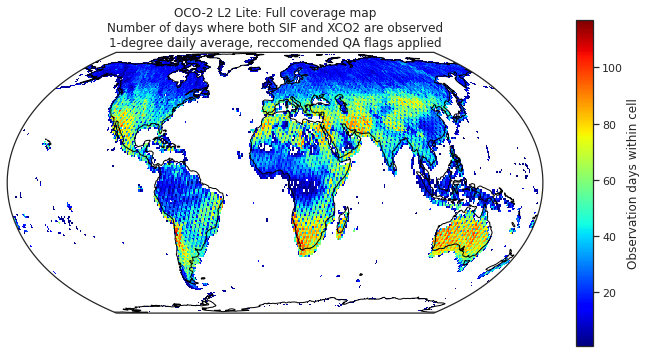

In [437]:
# Coverage map
DS_daily_counts = df_daily_counts.to_xarray()

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.EqualEarth()})

ax.set_global()
xarray.plot.imshow(DS_daily_counts.sif.T, transform=ccrs.PlateCarree(),
                   cmap="jet", cbar_kwargs={"label": "Observation days within cell"}, ax=ax)
ax.coastlines()
ax.set_title("OCO-2 L2 Lite: Full coverage map\n" 
             "Number of days where both SIF and XCO2 are observed\n"
             "1-degree daily average, reccomended QA flags applied")

plt.savefig("../plots/coverage_map_1degree_daily.png")

In [439]:
# Convert to dataset
DS_grid_daily = df_grid_daily.set_index(["lon", "lat", "time"]).to_xarray()
DS_grid_daily

<xarray.Dataset>
Dimensions:  (lat: 168, lon: 360, time: 2156)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -84.5 -83.5 -82.5 -81.5 -80.5 ... 79.5 80.5 81.5 82.5
  * time     (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2020-07-31
Data variables:
    sif      (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan
    xco2     (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan

In [449]:
# Compute cross covariance for each grid cell (maybe chunk dimensions first)
# X = DS_grid_daily.sif.chunk({"lon": "auto", "lat": "auto"})
# Y = DS_grid_daily.xco2.chunk({"lon": "auto", "lat": "auto"})
X = DS_grid_daily.sif
Y = DS_grid_daily.xco2
DS_xcov = apply_cross_covariance(X, Y, lag=90)

DS_xcov

<xarray.DataArray (lon: 360, lat: 168)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -84.5 -83.5 -82.5 -81.5 -80.5 ... 79.5 80.5 81.5 82.5

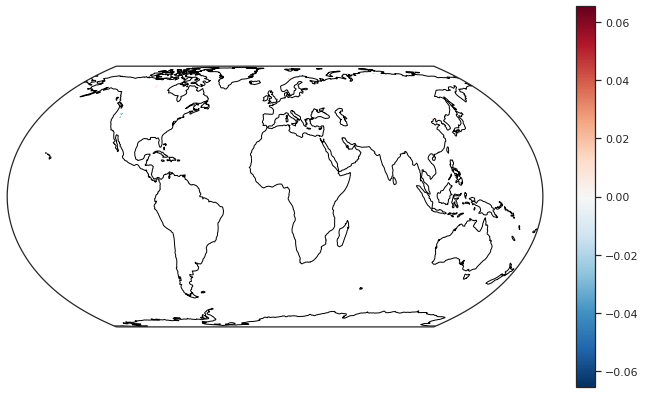

In [450]:
## NOTE: before reporting this, study optimal lag in days, also as about how to handle nans for denominator
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={"projection": ccrs.EqualEarth()})

ax.set_global()
xarray.plot.imshow(DS_xcov.T, transform=ccrs.PlateCarree(), ax=ax)
ax.coastlines()

## Monthly

In [125]:
time = pd.date_range("2014-09", "2020-07", freq="1MS").to_frame(name="time")

# Cut datasets to a regular grid and resample to daily averages within each grid cell
df_sif_monthly = (
    regrid(DS_sif)
    .groupby(["lon", "lat"])
    .resample("1MS")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)
df_xco2_monthly = (
    regrid(DS_xco2)
    .groupby(["lon", "lat"])
    .resample("1MS")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)

# Merge dataframes
# df_sif_daily_full = pd.merge(time, df_sif_daily, on=["time"], how="outer")
# df_xco2_daily_full = pd.merge(time, df_xco2_daily, on=["time"], how="outer")
df_grid_monthly = pd.merge(df_sif_monthly, df_xco2_monthly, on=["lon", "lat", "time"], how="outer")
df_grid_monthly

,lon,lat,time,sif,xco2
0,-179.5,-84.5,2014-11-01,0.214245,NaN
1,-179.5,-84.5,2014-12-01,0.145795,NaN
2,-179.5,-84.5,2015-01-01,0.130763,NaN
3,-179.5,-84.5,2015-02-01,NaN,NaN
4,-179.5,-84.5,2015-03-01,NaN,NaN
...,...,...,...,...,...
3650310,179.5,61.5,2020-05-01,NaN,NaN
3650311,179.5,61.5,2020-06-01,NaN,411.998230
3650312,179.5,72.5,2020-05-01,NaN,415.548920
3650313,179.5,72.5,2020-06-01,NaN,410.323120


In [126]:
# Check coverage
df_monthly_counts = df_grid_monthly.dropna().groupby(["lon", "lat"]).count()
df_monthly_counts

time  sif  xco2
lon    lat                   
-179.5 -20.5     2    2     2
       -19.5    45   45    45
       -18.5    29   29    29
       -17.5    28   28    28
       -16.5    35   35    35
...            ...  ...   ...
 179.5  67.5    10   10    10
        68.5    13   13    13
        69.5     8    8     8
        70.5     9    9     9
        71.5    11   11    11

[18154 rows x 3 columns]

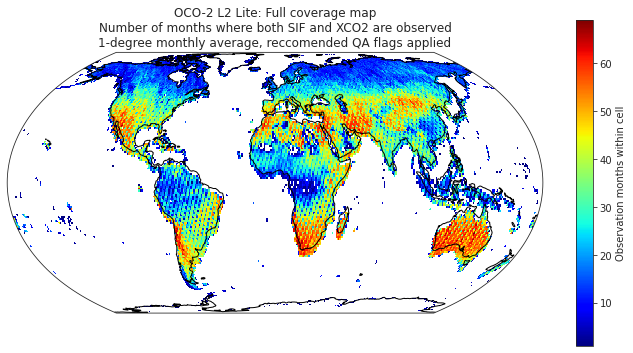

In [127]:
# Coverage map
DS_monthly_counts = df_monthly_counts.to_xarray()

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.EqualEarth()})

ax.set_global()
xarray.plot.imshow(DS_monthly_counts.sif.T, transform=ccrs.PlateCarree(),
                   cmap="jet", cbar_kwargs={"label": "Observation months within cell"}, ax=ax)
ax.coastlines()
ax.set_title("OCO-2 L2 Lite: Full coverage map\n" 
             "Number of months where both SIF and XCO2 are observed\n"
             "1-degree monthly average, reccomended QA flags applied")

plt.savefig("../plots/coverage_map_1degree_monthly.png")

In [128]:
# Convert to dataset
DS_grid_monthly = df_grid_monthly.set_index(["lon", "lat", "time"]).to_xarray()
DS_grid_monthly

<xarray.Dataset>
Dimensions:  (lat: 168, lon: 360, time: 71)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -84.5 -83.5 -82.5 -81.5 -80.5 ... 79.5 80.5 81.5 82.5
  * time     (time) datetime64[ns] 2014-09-01 2014-10-01 ... 2020-07-01
Data variables:
    sif      (lon, lat, time) float32 nan nan 0.21424477 ... nan nan nan
    xco2     (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan

In [135]:
# Compute cross covariance for each grid cell
DS_xcov_monthly = apply_cross_covariance(DS_grid_monthly.sif, DS_grid_monthly.xco2, lag=3)

DS_xcov_monthly

<xarray.DataArray (lon: 360, lat: 168)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -84.5 -83.5 -82.5 -81.5 -80.5 ... 79.5 80.5 81.5 82.5

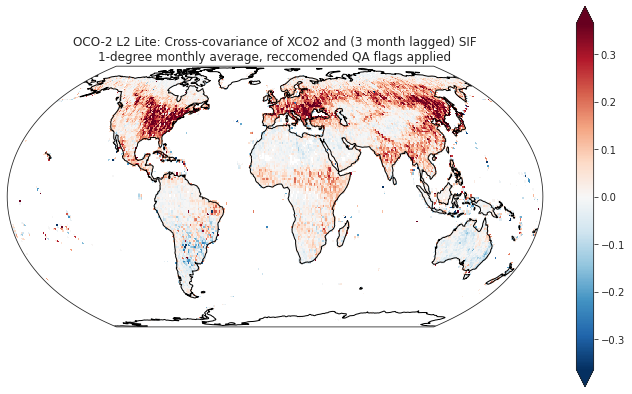

In [139]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={"projection": ccrs.EqualEarth()})

ax.set_global()
xarray.plot.imshow(DS_xcov_monthly.T, robust=True,
                   transform=ccrs.PlateCarree(), ax=ax)
ax.coastlines()
ax.set_title("OCO-2 L2 Lite: Cross-covariance of XCO2 and (3 month lagged) SIF\n" 
             "1-degree monthly average, reccomended QA flags applied")

plt.savefig("../plots/cross-cov_1degree_monthly.png");